# WAV2VEC2 training


This code provides the necessary functions for training the Speech Transformer WAV2VEC2

# Set up
---

## Install libraries

In [ ]:
!pip install transformers
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import librosa
from transformers import AutoProcessor, Wav2Vec2ForSequenceClassification,AutoFeatureExtractor,Wav2Vec2Model
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch
import os
import pandas as pd
from google.colab import drive
import numpy as np

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import ParameterGrid

from tabulate import tabulate
import math

from sklearn.utils import resample
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
import pytz

import pdb
import re

import librosa

pd.options.mode.chained_assignment = None

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

## Connect drive and select device

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Audio transformations
---

## Load audios

In [ ]:
def get_audio_waves(data):
  audio_path = '/content/gdrive/MyDrive/daiwoz/audios/'
  waves = {}
  for id_ in tqdm(data.patient_id.unique()):
    audio, sr = librosa.load(f"{audio_path}{id_}_AUDIO.wav",sr=None)
    waves.setdefault(id_,(audio,sr))

  return waves

## Pre-compute Wav2Vec2 embeddings

In [ ]:
def compute_embeddings(data,waves,model,tokenizer):
  for question_ in tqdm(data.question.unique()):
    question_embeddings = {}
    question_d = data.loc[(data.question == question_)]
    question_d["intervention_time"] = question_d["end_time"] - question_d["start_time"]

    median_intervetion = int(question_d.intervention_time.median())
    median_intervetion = median_intervetion if median_intervetion > 1 else 1
    median_intervetion = median_intervetion if median_intervetion < 25 else 25
    for id_ in data.loc[data.question == question_].patient_id.unique():
      question_data = data.loc[(data.patient_id==id_) & (data.question == question_)]
      question_data["intervention_time"] = question_data["end_time"] - question_data["start_time"]

      patient_id = question_data.patient_id.values[0]
      start_time = question_data.start_time.values[0]  # Start time in seconds
      end_time = question_data.end_time.values[0]  # End time in seconds

      audio,sr = waves[patient_id]

      start_sample = int(start_time * sr)  # Convert start time to sample index
      end_sample = int(end_time * sr)

      trimmed_audio = audio[start_sample:end_sample]

      input_values = tokenizer(audio,sampling_rate=sr, return_tensors='pt', max_length=median_intervetion*sr, padding="max_length", truncation=True).to("cuda")
      with torch.no_grad():
        mo = model(input_values["input_values"])

      embed = mo.last_hidden_state.squeeze()

      question_embeddings.setdefault(id_,embed)

    torch.save(question_embeddings,f"/content/gdrive/MyDrive/daiwoz/question_embeddings/{question_}_embeddings.pt")

In [ ]:
def compute_embeddings_questions(waves):
  tokenizer = AutoFeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")
  model = Wav2Vec2Model.from_pretrained("superb/wav2vec2-base-superb-er").to("cuda")
  compute_embeddings(data,waves,model,tokenizer)

data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/best_questions.csv",index_col=0).reset_index().rename(columns={"value":"intervention","id":"patient_id","index":"id"})
waves = get_audio_waves(data)
compute_embeddings_questions(waves)

## Dataset

In [ ]:
class DWDataset(torch.utils.data.Dataset):
    """
    A PyTorch dataset for sentiment analysis.

    Args:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Attributes:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index): Returns a single sample from the dataset.
    """

    def __init__(self, data):
        self.data = data.reset_index(drop=True).reset_index().rename(columns={"index":"id"})
        self.data_labels= self.data['PHQ8_Binary'].values
        self.embeddings = self.get_embeddings()


    def get_embeddings(self):
      question = self.data.question.unique()[0]
      return torch.load(f"/content/gdrive/MyDrive/daiwoz/question_embeddings/{question}_embeddings_er.pt",)

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """

        return len(self.data)


    def __getitem__(self, index):
        """
        Returns a single sample from the dataset.

        Args:
            index (int): The index of the sample to return.

        Returns:
            dict: A dictionary containing the embeddings,label,patient_id and index.
        """

        label = self.data.iloc[index]['PHQ8_Binary']
        patient_id = self.data.iloc[index]['patient_id']
        embeddings = self.embeddings[patient_id]

        return {"embeddings":embeddings,
                'label': torch.tensor(label),
                'patient_id':patient_id,
                "id":index}

# Utils

### Split function

In [ ]:
def split_dataset(df, test_size=0.15, val_size=0.2, random_state=42):
  """
  Function that splits a df taking in consideration balancing o Gender, PHQ and length of intervention.

  Params
  ---
    -df: The data to split
    -test_size: the size of the test set
    -val_size: the size of the validation set out of the remaining set after extracting the test set.
    -random_state: The seed, for reproducibility

  Returns
  ---
    - The same dataframe with a column name 'split' that indicates where each data point corresponds

  """
    # Ensure the 'gender' column is numerical
    if df['Gender'].dtype == 'object':
        df['Gender'] = df['Gender'].astype('category').cat.codes

    # Combine the 'gender' and 'label' columns into a new 2D array
    y = df[['Gender', 'PHQ8_Binary']].values


    try:
      # Split the DataFrame into three equal parts representing short, medium, and long texts
      labels=['short', 'medium', 'long']
      df['text_length_category'] = pd.qcut(df['word_count'], 3, labels=labels)
    except:
      labels=['short', 'long']
      # Split into 'short' and 'long' based on the median
      median = df['word_count'].median()
      df['text_length_category'] = np.where(df['word_count'] <= median, 'short', 'long')


    df_result = pd.DataFrame()

    # Loop over each category
    for category in labels:
        df_temp = df[df['text_length_category'] == category]

        # Create the initial splitter
        initial_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        # Split out the test set
        for other_index, test_index in initial_split.split(df_temp, df_temp[['Gender', 'PHQ8_Binary']].values):
            df_other, df_test = df_temp.iloc[other_index], df_temp.iloc[test_index]

        # Now create a new splitter for splitting the remaining data into train and validation sets
        train_val_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)

        y_other = df_other[['Gender', 'PHQ8_Binary']].values

        # Split the remaining data into train and validation sets
        for train_index, val_index in train_val_split.split(df_other, y_other):
            df_train, df_val = df_other.iloc[train_index], df_other.iloc[val_index]

        # Now assign labels to each set
        df_train['split'] = 'train'
        df_val['split'] = 'validation'
        df_test['split'] = 'test'

        df_temp = pd.concat([df_train, df_val, df_test])

        df_result = pd.concat([df_result, df_temp])

    return df_result


  ### Preprocess

In [ ]:
def drop_rows_below_percentile(df, column_name, percentile):
    # Step 1: Calculate the threshold number of words
    threshold = int(np.percentile(df[column_name].str.split().apply(len), percentile))

    # Step 2: Iterate over each row and count words
    word_counts = df[column_name].str.split().apply(len)

    # Step 3: Filter out rows below the threshold
    filtered_df = df[word_counts >= threshold].copy()

    return filtered_df

def preprocess_data(df):
    df.intervention = df.intervention.apply(lambda x: clean_text(x))
    df = split_dataset(df)
    #df = drop_rows_below_percentile(df,"intervention",10)

    return df


def inverse_frequency(df):
  neg, pos = np.bincount(df["PHQ8_Binary"])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
      total, pos, 100 * pos / total))

  weight_for_0 = (1 / (neg / total))
  weight_for_1 = (1 / (pos / total))

  class_weight = {0: weight_for_0, 1: weight_for_1}

  return class_weight

In [ ]:
def random_oversample(df,seed=42):
  # Separate the data based on class (assuming 'label' is the class column)
  # with 1 being the positive (minority) class
  df_minority = df[df['PHQ8_Binary'] == 1]
  df_majority = df[df['PHQ8_Binary'] == 0]

  # Perform oversampling on the minority class
  df_minority_oversampled = resample(df_minority,
                                      replace=True, # sample with replacement
                                      n_samples=int(len(df_majority)*0.95), # match number in majority class
                                      random_state=seed) # reproducible results

  # Combine the majority class with the oversampled minority class
  df_oversampled = pd.concat([df_majority, df_minority_oversampled])

  return df_oversampled

# Training functionalities
---

## Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0.0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.Inf
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, val_loss, model, train_dict, val_dict):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
        elif score > self.best_score:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
            self.counter = 0
        elif val_loss > self.val_loss_min + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss_min = val_loss
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        if self.verbose:
            print(f'Validation F1 increased ({self.val_f1_max:.6f} --> {val_f1:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1


## Experiment


In [ ]:
class Experiment:
  def __init__(self,model,criterion,optimizer,scheduler,early_stopper,writer):
    self.criterion = criterion
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.early_stopping = early_stopper
    self.model = model
    self.tb = writer

  def fit(self,num_epochs,train_data,val_data,verbose=0):

    self.train_loss = []
    self.val_loss = []

    for epoch in range(num_epochs):
       if verbose==1:
        print(f"\n--- Epoch {epoch+1} ---")

       train_dict = self.loop(train_data,self.optimizer,self.criterion,epoch,is_train=True)
       val_dict = self.loop(val_data,self.optimizer,self.criterion,epoch,is_train=False)


       self.train_loss.append(train_dict["loss"])
       self.val_loss.append(val_dict["loss"])


       self.track_metrics(train_dict,epoch,"train")
       self.track_metrics(val_dict,epoch,"validation")

       self.scheduler.step()

       if verbose == 1:
        self.print_metrics(train_dict,"Train")
        self.print_metrics(val_dict,"Validation")

       current_F1 = self.get_metrics(val_dict)["F1"]

       self.early_stopping(current_F1,self.val_loss[-1], self.model, train_dict, val_dict)
       if self.early_stopping.early_stop:
          print(f"Early stopping: detected overfitting on validation loss")
          break



    self.best_train_metrics = self.get_metrics(self.early_stopping.best_train_dict)
    self.best_val_metrics = self.get_metrics(self.early_stopping.best_val_dict)

    self.best_val_probs = self.early_stopping.best_val_dict["probs"]
    if verbose == 2 or verbose == 1:
      self.print_metrics(train_dict,"Train")
      self.print_metrics(self.early_stopping.best_val_dict,"Validation")


  def loop(self, data_loader, optimizer, criterion, epoch, is_train):

    if is_train:
        self.model.train()
        progress_desc = 'Train'
    else:
        self.model.eval()
        progress_desc = 'Validation'

    progress_bar = tqdm(data_loader,
                        desc=f'{progress_desc} Epoch {epoch+1}',
                        leave=False,
                        disable=False)

    running_loss = 0.0
    total_samples = 0
    running_tp = 0
    running_tn = 0
    running_fp = 0
    running_fn = 0
    preds_auc = []
    labels_auc = []
    ids=[]

    # Include the entire loop under either the no_grad context (if not training)
    # or the default context (if training)
    with torch.set_grad_enabled(is_train):
        for data in progress_bar:
            input_ids, labels,patient_id = data['embeddings'].to(device),data["label"].to(device),data["patient_id"]

            if is_train:
                optimizer.zero_grad()

            outputs = self.model(input_ids)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)
            loss = criterion(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * input_ids.size(0)
            running_tp += torch.sum((labels == 1) & (preds == 1))
            running_tn += torch.sum((labels == 0) & (preds == 0))
            running_fp += torch.sum((labels == 0) & (preds == 1))
            running_fn += torch.sum((labels == 1) & (preds == 0))

            labels_auc += labels.cpu().detach().numpy().tolist()
            preds_auc += probabilities[:,1].cpu().detach().numpy().tolist()
            ids += patient_id.detach().numpy().tolist()


            total_samples += input_ids.size(0)


    auc = roc_auc_score(labels_auc, preds_auc)

    total_samples = running_tn + running_tp +  running_fn + running_fp

    epoch_dict = {"loss":running_loss/total_samples,"probs": self.get_probs_dataframe(preds_auc,ids),
                  "tp":running_tp, "tn":running_tn, "fp":running_fp, "fn":running_fn,
                  "auc":auc}

    return epoch_dict


  def get_metrics(self, epoch_dict):
      tp = epoch_dict["tp"].item()
      fp = epoch_dict["fp"].item()
      tn = epoch_dict["tn"].item()
      fn = epoch_dict["fn"].item()
      loss = epoch_dict["loss"].item()
      auc = epoch_dict["auc"]

      total_samples = tp + fp + tn + fn
      acc = (tp + tn) / total_samples
      precision = tp / (tp + fp) if tp + fp > 0. else 0.
      recall = tp / (tp + fn) if tp + fn > 0. else 0.
      specificity = tn / (tn + fp) if tn + fp > 0 else 0
      F1 = 2 * (precision * recall) / (precision + recall) if precision+recall > 0. else 0.
      b_accuracy = (recall + specificity) / 2

      metrics_dict = {
          "tp": tp,
          "fp": fp,
          "tn": tn,
          "fn": fn,
          "loss": loss,
          "auc": auc,
          "accuracy": acc,
          "precision": precision,
          "recall": recall,
          "specificity": specificity,
          "F1": F1,
          "balanced_accuracy": b_accuracy
      }

      return metrics_dict

  def print_metrics(self,epoch_dict,pl):
    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]



    metrics_data = [
      ["Loss",        f"{loss:.3f}"       , "TP", f"{tp:.1f}"],
      ["Accuracy",    f"{acc:.3f}"        , "FP", f"{fp:.1f}"],
      ["F1 Score",    f"{F1:.3f}"         , "TN", f"{tn:.1f}"],
      ["Sensitivity", f"{recall:.3f}"     , "FN", f"{fn:.1f}"],
      ["Specificity", f"{specificity:.3f}", ""  , ""],
      ["Balanced Acc",f"{b_accuracy:.3f}" , ""  , ""],
      ["AUC",         f"{auc:.3f}"        , ""  , ""],
    ]


    print(f"\n{pl} Metrics Report")
    print(tabulate(metrics_data, headers=["Metric", "Value", "Metric", "Value"], tablefmt='pretty'))


  def track_metrics(self,epoch_dict,epoch,pl):

    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]

    self.tb.add_scalar(f"Loss/{pl}", loss, epoch)
    self.tb.add_scalar(f"Accuracy/{pl}", acc, epoch)
    self.tb.add_scalar(f"F1-Score/{pl}", F1, epoch)
    self.tb.add_scalar(f"Sensibility/{pl}", recall, epoch)
    self.tb.add_scalar(f"Specificity/{pl}", specificity, epoch)
    self.tb.add_scalar(f"tp/{pl}", tp, epoch)
    self.tb.add_scalar(f"fp/{pl}", fp, epoch)
    self.tb.add_scalar(f"tn/{pl}", tn, epoch)
    self.tb.add_scalar(f"fn/{pl}", fn, epoch)
    self.tb.add_scalar(f"AUC/{pl}", auc, epoch)
    self.tb.add_scalar(f"Balanced-Accuracy/{pl}", b_accuracy, epoch)

  def plot_loss(self):
    # Plot the metrics on the same chart
    plt.plot(self.train_loss, label='Training Loss')
    plt.plot(self.val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def get_probs_dataframe(self,probs, ids):

    df = pd.DataFrame(data=list(zip(ids,probs)),columns=["id","probs"])

    return df

  def predict(self, dataset, cutoff=0.5):
      self.model.eval()
      preds = []
      labels = []
      probs_auc = []
      ids = []

      progress_bar = tqdm(dataset,
                      desc=f'Test',
                      leave=False,
                      disable=False)

      for datap in progress_bar:

          input_ids, lab,patient_id = datap["embeddings"].to(device), datap["label"].to(device),datap["patient_id"]

          outputs = self.model(input_ids)

          probabilities = torch.nn.functional.softmax(outputs, dim=1)
          _, predis = torch.max(probabilities, 1)

          preds.append(predis)
          probs_auc.append(probabilities[:,1])
          labels.append(lab)
          ids.append(patient_id)

      preds = torch.stack(preds).cpu().numpy()
      labels = torch.stack(labels).cpu().numpy()
      probs_auc = torch.stack(probs_auc).cpu().detach().numpy()
      ids  = torch.stack(ids).detach().numpy()

      corrects = np.sum(preds == labels)
      tp = np.sum((labels == 1) & ((probs_auc >= cutoff) == 1))
      tn = np.sum((labels == 0) & ((probs_auc >= cutoff) == 0))
      fp = np.sum((labels == 0) & ((probs_auc >= cutoff) == 1))
      fn = np.sum((labels == 1) & ((probs_auc >= cutoff) == 0))



      auc = roc_auc_score(labels,probs_auc)

      epoch_test = {"loss":torch.tensor(0),"probs": self.get_probs_dataframe(probs_auc.flatten(),ids.flatten()),
                    "tp":torch.tensor(tp), "tn":torch.tensor(tn), "fp":torch.tensor(fp), "fn":torch.tensor(fn),
                    "auc":auc}

      self.test_probs = self.get_probs_dataframe(probs_auc.flatten(),ids.flatten())
      self.test_dict = self.get_metrics(epoch_test)
      self.print_metrics(epoch_dict=epoch_test,pl="Test")
      return preds, labels, self.test_dict


## Model definition

In [ ]:
class Wav2VecModel(nn.Module):
    def __init__(self):
        super(Wav2VecModel, self).__init__()

        self.f1 = nn.Linear(768, 256)

        self.out = nn.Linear(256,2)

    def forward(self, input_data):
        x = input_data

        x = torch.mean(x,dim=1)

        x = self.f1(x)

        x = self.out(x)

        return x

## Evaluation functions

In [ ]:
def create_metrics_dataframe_cv(experiments,dtst):
    metrics_dicts = []

    for i, exp in enumerate(experiments):
      if dtst == "val":
        metrics = exp.best_val_metrics.copy()
      else:
        metrics = exp.test_dict.copy()

      metrics['fold'] = i + 1
      metrics_dicts.append(metrics)


    df = pd.DataFrame(metrics_dicts)
    df.set_index('fold', inplace=True)

    summary_dict = {}
    for column in df.columns:
        summary_dict[column] = {
            'mean': df[column].mean(),
            'std': df[column].std()
        }

    summary_df = pd.DataFrame(summary_dict)

    # Concatenate the dataframes along the row axis (i.e., add the summary dataframe as new rows)
    full_df = pd.concat([df, summary_df], axis=0)

    # Apply a formatting function to each numeric value in the dataframe, to limit the number of decimal places
    full_df = full_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


    return full_df

def get_predictions(question,experiments,t):
    probas_dicts = []

    for i, exp in enumerate(experiments):
      metrics = exp.best_val_probs if t == "val" else exp.test_probs
      probas_dicts.append(metrics.rename(columns={"probs":f"probs_model_{i}"}))

    df_merged = pd.DataFrame({'id': []})
    for df in probas_dicts:
      df_merged = df_merged.merge(df, on='id', how='outer')

    df_merged.to_csv(f'/content/gdrive/MyDrive/daiwoz/probas/wav2vec2_{question}_{t}.csv')

    return df


# Cross-Validation
---

## 1 fold execution

In [ ]:
def one_fold(train,val,test,batch_size,seed,params,writer,epochs,device):
  exps = []
  torch.manual_seed(seed)


  train_dataloader =  DataLoader(train, batch_size=batch_size, shuffle=True,drop_last=True)
  val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test)

  criterion = nn.CrossEntropyLoss()

  stopper = EarlyStopping(patience=5)

  model = Wav2VecModel().to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])

  # Create the learning rate scheduler.
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params["scheduler_step"], gamma=params["scheduler_gamma"])

  exp = Experiment(model,criterion,optimizer,scheduler,stopper,writer)
  exp.fit(epochs,train_dataloader,val_dataloader,verbose=2)
  exp.predict(test_dataloader)

  exps.append(exp)

  for ele in params:
    if isinstance(params[ele],list):
      params[ele] = ', '.join([str(item) for item in params[ele]])

  writer.add_hparams(params,exp.best_val_metrics)

  model.to("cpu")
  return exp


## AudiBert process

In [ ]:
def question_model_random(data,data_test,params,tokenizer,device,folds=5,epochs=50,batch_size=64):
  k = folds
  # Assume df is your DataFrame and 'label' is the column with the labels
  # Create a StratifiedKFold object
  seed = 42

  model_id = datetime.now(pytz.timezone('Europe/Madrid')).strftime(f'%Y%m%d%_H%M')
  log_dir = f'/content/gdrive/MyDrive/daiwoz/runs/CV/wav2vec2/{model_id}'
  writer = SummaryWriter(log_dir = log_dir)

  experiments = []
  datasets = []
  # Iterate over each fold
  train_df = data.loc[data.split=="train"]
  valid_df = data.loc[data.split=="validation"]

  train_df = random_oversample(train_df)


  train_dataset = DWDataset(train_df)

  validation_dataset = DWDataset(valid_df)
  test_dataset = DWDataset(data_test)


  for i in range(folds):
    # Print the sizes of the training and validation sets
    print(f"\n------ Fold {i + 1} --------")
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")

    fold_execution = one_fold(train_dataset,validation_dataset,test_dataset,batch_size,seed,params,writer,epochs,device)
    experiments.append(fold_execution)
    datasets.append((train_df,valid_df))

    torch.save(fold_execution.model, f"/content/gdrive/MyDrive/daiwoz/models2/TempBERT_gs_{model_id}_{i}.pth")

    seed+=1

  return experiments,datasets

  writer.flush()
  writer.close()

# Execution
---

## Load data

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/best_questions.csv",index_col=0).rename(columns={"value":"intervention","id":"patient_id"})
data.head(1)

,patient_id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count
0,300,good,0,62.328,63.178,how are you doing today,1,2,0,test,1


In [ ]:
def iterate_over_all_questions(data):
  #model = AutoModel.from_pretrained("roberta-base")
  tokenizer = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
  param_grid = {
    'learning_rate':  1e-3,
    'dataset': 'top15_questions',  # Replace with the names of your datasets.
    'scheduler_step': 11,
    'scheduler_gamma': 0.25,
    'pos_weight': 1
  }

  batch_size = 32
  scores = []
  models = []
  datasets = []
  loss_curves = []

  for value in data.question.unique():
    #if value not in [2]: continue
    print(f"\n-------- Question {value} -------")

    question_data = preprocess_data(data.loc[data.question==value].dropna(axis=0))
    test_data = question_data.loc[question_data.split=="test"]
    train_data = question_data.loc[question_data.split != "test"]

    exps,dts = question_model_random(train_data,test_data,param_grid,tokenizer,device,folds=3,batch_size=batch_size)


    eval = create_metrics_dataframe_cv(exps,"val")
    test = create_metrics_dataframe_cv(exps,"test")

    probas = get_predictions(value,exps,"val")
    probas_t = get_predictions(value,exps,"test")


    mean_f1_eval = eval.iloc[-2].F1
    std_f1_eval = eval.iloc[-1].F1

    mean_f1_test = test.iloc[-2].F1
    std_f1_test = test.iloc[-1].F1


    mean_auc_eval = eval.iloc[-2].auc
    std_auc_eval = eval.iloc[-1].auc

    mean_auc_test = test.iloc[-2].auc
    std_auc_test = test.iloc[-1].auc



    mean_recall_eval = eval.iloc[-2].recall
    std_recall_eval = eval.iloc[-1].recall

    mean_recall_test = test.iloc[-2].recall
    std_recall_test = test.iloc[-1].recall



    print(f"\nQuestion {value}: val F1: {mean_f1_eval} +/- {std_f1_eval} || test F1: {mean_f1_test} +/- {std_f1_test} ")

    scores.append((value,mean_f1_eval,std_f1_eval,
                   mean_auc_eval,std_auc_eval,
                   mean_recall_eval,std_recall_eval,
                   mean_f1_test,std_f1_test,
                   mean_auc_test,std_auc_eval,
                   mean_recall_test,std_recall_test
                   ))

    loss_curves.append([(exp.train_loss,exp.val_loss) for exp in exps])

    models.append(exps)
    datasets.append(dts)


  return pd.DataFrame(data = scores,columns=["question","V. F1"," V. F1 std",
                                             "V. auc","V. auc std",
                                             "V. recall","V. recall std",
                                             "T. F1","T. F1 std",
                                             "T. auc","T. auc std",
                                             "T. recall","T. recall std"]),models,datasets,loss_curves

# Start process

In [ ]:
results,models,datasets,loss_history = iterate_over_all_questions(data)
results


-------- Question 0 -------

------ Fold 1 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.484848).  Saving model ...


Validation F1 increased (0.484848 --> 0.562500).  Saving model ...


Validation F1 increased (0.562500 --> 0.640000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.481 |   TP   | 46.0  |
|   Accuracy   | 0.744 |   FP   | 10.0  |
|   F1 Score   | 0.692 |   TN   | 73.0  |
| Sensitivity  | 0.597 |   FN   | 31.0  |
| Specificity  | 0.880 |        |       |
| Balanced Acc | 0.738 |        |       |
|     AUC      | 0.857 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.663 |   TP   |  8.0  |
|   Accuracy   | 0.719 |   FP   |  7.0  |
|   F1 Score   | 0.640 |   TN   | 15.0  |
| Sensitivity  | 0.800 |   FN   |  2.0  |
| Specificity  | 0.682 |        |       |
| Balanced Acc | 0.741 |        |       |
|     AUC      | 0.709 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.690 |   FP   |  2.0  |
|   F1 Score   | 0.182 |   TN   | 19.0  |
| Sensitivity  | 0.125 |   FN   |  7.0  |
| Specificity  | 0.905 |        |       |
| Balanced Acc | 0.515 |        |       |
|     AUC      | 0.560 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.285714).  Saving model ...


Validation F1 increased (0.285714 --> 0.454545).  Saving model ...


Validation F1 increased (0.454545 --> 0.583333).  Saving model ...


Validation F1 increased (0.583333 --> 0.636364).  Saving model ...


Validation F1 increased (0.636364 --> 0.666667).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.393 |   TP   | 58.0  |
|   Accuracy   | 0.787 |   FP   | 14.0  |
|   F1 Score   | 0.773 |   TN   | 68.0  |
| Sensitivity  | 0.744 |   FN   | 20.0  |
| Specificity  | 0.829 |        |       |
| Balanced Acc | 0.786 |        |       |
|     AUC      | 0.914 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.596 |   TP   |  7.0  |
|   Accuracy   | 0.781 |   FP   |  4.0  |
|   F1 Score   | 0.667 |   TN   | 18.0  |
| Sensitivity  | 0.700 |   FN   |  3.0  |
| Specificity  | 0.818 |        |       |
| Balanced Acc | 0.759 |        |       |
|     AUC      | 0.750 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.690 |   FP   |  2.0  |
|   F1 Score   | 0.182 |   TN   | 19.0  |
| Sensitivity  | 0.125 |   FN   |  7.0  |
| Specificity  | 0.905 |        |       |
| Balanced Acc | 0.515 |        |       |
|     AUC      | 0.560 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 167
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Validation F1 increased (0.476190 --> 0.521739).  Saving model ...


Validation F1 increased (0.521739 --> 0.526316).  Saving model ...


Validation F1 increased (0.526316 --> 0.583333).  Saving model ...


Validation F1 increased (0.583333 --> 0.608696).  Saving model ...


Validation F1 increased (0.608696 --> 0.636364).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.425 |   TP   | 60.0  |
|   Accuracy   | 0.806 |   FP   | 14.0  |
|   F1 Score   | 0.795 |   TN   | 69.0  |
| Sensitivity  | 0.779 |   FN   | 17.0  |
| Specificity  | 0.831 |        |       |
| Balanced Acc | 0.805 |        |       |
|     AUC      | 0.903 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.609 |   TP   |  7.0  |
|   Accuracy   | 0.750 |   FP   |  5.0  |
|   F1 Score   | 0.636 |   TN   | 17.0  |
| Sensitivity  | 0.700 |   FN   |  3.0  |
| Specificity  | 0.773 |        |       |
| Balanced Acc | 0.736 |        |       |
|     AUC      | 0.741 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.690 |   FP   |  3.0  |
|   F1 Score   | 0.308 |   TN   | 18.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.857 |        |       |
| Balanced Acc | 0.554 |        |       |
|     AUC      | 0.542 |        |       |
+--------------+-------+--------+-------+

Question 0: val F1: 0.648 +/- 0.017 || test F1: 0.224 +/- 0.073 

-------- Question 1 -------

------ Fold 1 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.622 |   TP   | 69.0  |
|   Accuracy   | 0.675 |   FP   | 44.0  |
|   F1 Score   | 0.726 |   TN   | 39.0  |
| Sensitivity  | 0.896 |   FN   |  8.0  |
| Specificity  | 0.470 |        |       |
| Balanced Acc | 0.683 |        |       |
|     AUC      | 0.758 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.999 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.445 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.464 |   FP   | 11.0  |
|   F1 Score   | 0.348 |   TN   |  9.0  |
| Sensitivity  | 0.500 |   FN   |  4.0  |
| Specificity  | 0.450 |        |       |
| Balanced Acc | 0.475 |        |       |
|     AUC      | 0.600 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.450000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.576 |   TP   | 59.0  |
|   Accuracy   | 0.744 |   FP   | 22.0  |
|   F1 Score   | 0.742 |   TN   | 60.0  |
| Sensitivity  | 0.756 |   FN   | 19.0  |
| Specificity  | 0.732 |        |       |
| Balanced Acc | 0.744 |        |       |
|     AUC      | 0.812 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.802 |   TP   |  9.0  |
|   Accuracy   | 0.312 |   FP   | 21.0  |
|   F1 Score   | 0.450 |   TN   |  1.0  |
| Sensitivity  | 0.900 |   FN   |  1.0  |
| Specificity  | 0.045 |        |       |
| Balanced Acc | 0.473 |        |       |
|     AUC      | 0.432 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.750 |   FP   |  2.0  |
|   F1 Score   | 0.462 |   TN   | 18.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 0.900 |        |       |
| Balanced Acc | 0.637 |        |       |
|     AUC      | 0.588 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 165
Validation set size: 32


Validation F1 increased (-inf --> 0.285714).  Saving model ...


Validation F1 increased (0.285714 --> 0.344828).  Saving model ...


Validation F1 increased (0.344828 --> 0.380952).  Saving model ...


Validation F1 increased (0.380952 --> 0.434783).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.502 |   TP   | 57.0  |
|   Accuracy   | 0.775 |   FP   | 14.0  |
|   F1 Score   | 0.760 |   TN   | 67.0  |
| Sensitivity  | 0.722 |   FN   | 22.0  |
| Specificity  | 0.827 |        |       |
| Balanced Acc | 0.774 |        |       |
|     AUC      | 0.858 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.826 |   TP   |  5.0  |
|   Accuracy   | 0.594 |   FP   |  8.0  |
|   F1 Score   | 0.435 |   TN   | 14.0  |
| Sensitivity  | 0.500 |   FN   |  5.0  |
| Specificity  | 0.636 |        |       |
| Balanced Acc | 0.568 |        |       |
|     AUC      | 0.423 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.643 |   FP   |  5.0  |
|   F1 Score   | 0.375 |   TN   | 15.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.562 |        |       |
|     AUC      | 0.506 |        |       |
+--------------+-------+--------+-------+

Question 1: val F1: 0.454 +/- 0.021 || test F1: 0.395 +/- 0.059 

-------- Question 2 -------

------ Fold 1 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.266667).  Saving model ...


Validation F1 increased (0.266667 --> 0.333333).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.439 |   TP   | 61.0  |
|   Accuracy   | 0.781 |   FP   | 18.0  |
|   F1 Score   | 0.777 |   TN   | 64.0  |
| Sensitivity  | 0.782 |   FN   | 17.0  |
| Specificity  | 0.780 |        |       |
| Balanced Acc | 0.781 |        |       |
|     AUC      | 0.893 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.711 |   TP   |  3.0  |
|   Accuracy   | 0.600 |   FP   |  6.0  |
|   F1 Score   | 0.333 |   TN   | 15.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.524 |        |       |
|     AUC      | 0.540 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.519 |   FP   |  7.0  |
|   F1 Score   | 0.316 |   TN   | 11.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.611 |        |       |
| Balanced Acc | 0.472 |        |       |
|     AUC      | 0.407 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.518519).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.519 |   TP   | 52.0  |
|   Accuracy   | 0.750 |   FP   | 14.0  |
|   F1 Score   | 0.722 |   TN   | 68.0  |
| Sensitivity  | 0.667 |   FN   | 26.0  |
| Specificity  | 0.829 |        |       |
| Balanced Acc | 0.748 |        |       |
|     AUC      | 0.849 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.708 |   TP   |  7.0  |
|   Accuracy   | 0.567 |   FP   | 11.0  |
|   F1 Score   | 0.519 |   TN   | 10.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.476 |        |       |
| Balanced Acc | 0.627 |        |       |
|     AUC      | 0.614 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.407 |   FP   | 10.0  |
|   F1 Score   | 0.273 |   TN   |  8.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.444 |        |       |
| Balanced Acc | 0.389 |        |       |
|     AUC      | 0.383 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 161
Validation set size: 30


Validation F1 increased (-inf --> 0.514286).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.513 |   TP   | 58.0  |
|   Accuracy   | 0.731 |   FP   | 23.0  |
|   F1 Score   | 0.730 |   TN   | 59.0  |
| Sensitivity  | 0.744 |   FN   | 20.0  |
| Specificity  | 0.720 |        |       |
| Balanced Acc | 0.732 |        |       |
|     AUC      | 0.849 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.868 |   TP   |  9.0  |
|   Accuracy   | 0.433 |   FP   | 17.0  |
|   F1 Score   | 0.514 |   TN   |  4.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.190 |        |       |
| Balanced Acc | 0.595 |        |       |
|     AUC      | 0.656 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.407 |   FP   | 10.0  |
|   F1 Score   | 0.273 |   TN   |  8.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.444 |        |       |
| Balanced Acc | 0.389 |        |       |
|     AUC      | 0.432 |        |       |
+--------------+-------+--------+-------+

Question 2: val F1: 0.455 +/- 0.106 || test F1: 0.287 +/- 0.025 

-------- Question 4 -------

------ Fold 1 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.598 |   TP   | 46.0  |
|   Accuracy   | 0.742 |   FP   | 13.0  |
|   F1 Score   | 0.736 |   TN   | 49.0  |
| Sensitivity  | 0.697 |   FN   | 20.0  |
| Specificity  | 0.790 |        |       |
| Balanced Acc | 0.744 |        |       |
|     AUC      | 0.800 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.640 |   TP   |  3.0  |
|   Accuracy   | 0.767 |   FP   |  1.0  |
|   F1 Score   | 0.462 |   TN   | 20.0  |
| Sensitivity  | 0.333 |   FN   |  6.0  |
| Specificity  | 0.952 |        |       |
| Balanced Acc | 0.643 |        |       |
|     AUC      | 0.513 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.679 |   FP   |  4.0  |
|   F1 Score   | 0.308 |   TN   | 17.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.810 |        |       |
| Balanced Acc | 0.548 |        |       |
|     AUC      | 0.728 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.612 |   TP   | 23.0  |
|   Accuracy   | 0.656 |   FP   |  8.0  |
|   F1 Score   | 0.511 |   TN   | 61.0  |
| Sensitivity  | 0.390 |   FN   | 36.0  |
| Specificity  | 0.884 |        |       |
| Balanced Acc | 0.637 |        |       |
|     AUC      | 0.777 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.861 |   TP   |  9.0  |
|   Accuracy   | 0.300 |   FP   | 21.0  |
|   F1 Score   | 0.462 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.497 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.679 |   FP   |  3.0  |
|   F1 Score   | 0.182 |   TN   | 18.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 0.857 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.735 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 156
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Validation F1 increased (0.461538 --> 0.466667).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.599 |   TP   | 33.0  |
|   Accuracy   | 0.719 |   FP   |  7.0  |
|   F1 Score   | 0.647 |   TN   | 59.0  |
| Sensitivity  | 0.532 |   FN   | 29.0  |
| Specificity  | 0.894 |        |       |
| Balanced Acc | 0.713 |        |       |
|     AUC      | 0.772 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.713 |   TP   |  7.0  |
|   Accuracy   | 0.467 |   FP   | 14.0  |
|   F1 Score   | 0.467 |   TN   |  7.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.333 |        |       |
| Balanced Acc | 0.556 |        |       |
|     AUC      | 0.540 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.714 |   FP   |  2.0  |
|   F1 Score   | 0.200 |   TN   | 19.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 0.905 |        |       |
| Balanced Acc | 0.524 |        |       |
|     AUC      | 0.673 |        |       |
+--------------+-------+--------+-------+

Question 4: val F1: 0.463 +/- 0.003 || test F1: 0.230 +/- 0.068 

-------- Question 5 -------

------ Fold 1 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.400000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.538 |   TP   | 56.0  |
|   Accuracy   | 0.762 |   FP   | 17.0  |
|   F1 Score   | 0.747 |   TN   | 66.0  |
| Sensitivity  | 0.727 |   FN   | 21.0  |
| Specificity  | 0.795 |        |       |
| Balanced Acc | 0.761 |        |       |
|     AUC      | 0.825 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 1.103 |   TP   |  7.0  |
|   Accuracy   | 0.276 |   FP   | 20.0  |
|   F1 Score   | 0.400 |   TN   |  1.0  |
| Sensitivity  | 0.875 |   FN   |  1.0  |
| Specificity  | 0.048 |        |       |
| Balanced Acc | 0.461 |        |       |
|     AUC      | 0.315 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.769 |   FP   |  1.0  |
|   F1 Score   | 0.250 |   TN   | 19.0  |
| Sensitivity  | 0.167 |   FN   |  5.0  |
| Specificity  | 0.950 |        |       |
| Balanced Acc | 0.558 |        |       |
|     AUC      | 0.608 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.352941).  Saving model ...


Validation F1 increased (0.352941 --> 0.357143).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.483 |   TP   | 59.0  |
|   Accuracy   | 0.812 |   FP   | 11.0  |
|   F1 Score   | 0.797 |   TN   | 71.0  |
| Sensitivity  | 0.756 |   FN   | 19.0  |
| Specificity  | 0.866 |        |       |
| Balanced Acc | 0.811 |        |       |
|     AUC      | 0.886 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.891 |   TP   |  5.0  |
|   Accuracy   | 0.379 |   FP   | 15.0  |
|   F1 Score   | 0.357 |   TN   |  6.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.286 |        |       |
| Balanced Acc | 0.455 |        |       |
|     AUC      | 0.357 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.808 |   FP   |  2.0  |
|   F1 Score   | 0.545 |   TN   | 18.0  |
| Sensitivity  | 0.500 |   FN   |  3.0  |
| Specificity  | 0.900 |        |       |
| Balanced Acc | 0.700 |        |       |
|     AUC      | 0.592 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 163
Validation set size: 29


Validation F1 increased (-inf --> 0.352941).  Saving model ...


Validation F1 increased (0.352941 --> 0.357143).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.452 |   TP   | 60.0  |
|   Accuracy   | 0.831 |   FP   | 11.0  |
|   F1 Score   | 0.816 |   TN   | 73.0  |
| Sensitivity  | 0.789 |   FN   | 16.0  |
| Specificity  | 0.869 |        |       |
| Balanced Acc | 0.829 |        |       |
|     AUC      | 0.905 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.990 |   TP   |  5.0  |
|   Accuracy   | 0.379 |   FP   | 15.0  |
|   F1 Score   | 0.357 |   TN   |  6.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.286 |        |       |
| Balanced Acc | 0.455 |        |       |
|     AUC      | 0.363 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.654 |   FP   |  7.0  |
|   F1 Score   | 0.471 |   TN   | 13.0  |
| Sensitivity  | 0.667 |   FN   |  2.0  |
| Specificity  | 0.650 |        |       |
| Balanced Acc | 0.658 |        |       |
|     AUC      | 0.608 |        |       |
+--------------+-------+--------+-------+

Question 5: val F1: 0.371 +/- 0.025 || test F1: 0.422 +/- 0.154 

-------- Question 6 -------

------ Fold 1 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.473684).  Saving model ...


Validation F1 increased (0.473684 --> 0.482759).  Saving model ...


Validation F1 increased (0.482759 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.526316).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.500 |   TP   | 49.0  |
|   Accuracy   | 0.773 |   FP   | 14.0  |
|   F1 Score   | 0.772 |   TN   | 50.0  |
| Sensitivity  | 0.766 |   FN   | 15.0  |
| Specificity  | 0.781 |        |       |
| Balanced Acc | 0.773 |        |       |
|     AUC      | 0.846 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.620 |   TP   |  5.0  |
|   Accuracy   | 0.690 |   FP   |  5.0  |
|   F1 Score   | 0.526 |   TN   | 15.0  |
| Sensitivity  | 0.556 |   FN   |  4.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.653 |        |       |
|     AUC      | 0.611 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.731 |   FP   |  5.0  |
|   F1 Score   | 0.588 |   TN   | 14.0  |
| Sensitivity  | 0.714 |   FN   |  2.0  |
| Specificity  | 0.737 |        |       |
| Balanced Acc | 0.726 |        |       |
|     AUC      | 0.782 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.307692).  Saving model ...


Validation F1 increased (0.307692 --> 0.466667).  Saving model ...


Validation F1 increased (0.466667 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.583333).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.523 |   TP   | 53.0  |
|   Accuracy   | 0.781 |   FP   | 17.0  |
|   F1 Score   | 0.791 |   TN   | 47.0  |
| Sensitivity  | 0.828 |   FN   | 11.0  |
| Specificity  | 0.734 |        |       |
| Balanced Acc | 0.781 |        |       |
|     AUC      | 0.837 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.664 |   TP   |  7.0  |
|   Accuracy   | 0.655 |   FP   |  8.0  |
|   F1 Score   | 0.583 |   TN   | 12.0  |
| Sensitivity  | 0.778 |   FN   |  2.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.689 |        |       |
|     AUC      | 0.661 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  6.0  |
|   Accuracy   | 0.577 |   FP   | 10.0  |
|   F1 Score   | 0.522 |   TN   |  9.0  |
| Sensitivity  | 0.857 |   FN   |  1.0  |
| Specificity  | 0.474 |        |       |
| Balanced Acc | 0.665 |        |       |
|     AUC      | 0.789 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 154
Validation set size: 29


Validation F1 increased (-inf --> 0.133333).  Saving model ...


Validation F1 increased (0.133333 --> 0.466667).  Saving model ...


Validation F1 increased (0.466667 --> 0.480000).  Saving model ...


Validation F1 increased (0.480000 --> 0.500000).  Saving model ...


Validation F1 increased (0.500000 --> 0.545455).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.414 |   TP   | 55.0  |
|   Accuracy   | 0.836 |   FP   | 11.0  |
|   F1 Score   | 0.840 |   TN   | 52.0  |
| Sensitivity  | 0.846 |   FN   | 10.0  |
| Specificity  | 0.825 |        |       |
| Balanced Acc | 0.836 |        |       |
|     AUC      | 0.919 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.645 |   TP   |  6.0  |
|   Accuracy   | 0.655 |   FP   |  7.0  |
|   F1 Score   | 0.545 |   TN   | 13.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.650 |        |       |
| Balanced Acc | 0.658 |        |       |
|     AUC      | 0.639 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  5.0  |
|   Accuracy   | 0.731 |   FP   |  5.0  |
|   F1 Score   | 0.588 |   TN   | 14.0  |
| Sensitivity  | 0.714 |   FN   |  2.0  |
| Specificity  | 0.737 |        |       |
| Balanced Acc | 0.726 |        |       |
|     AUC      | 0.767 |        |       |
+--------------+-------+--------+-------+

Question 6: val F1: 0.552 +/- 0.029 || test F1: 0.566 +/- 0.038 

-------- Question 7 -------

------ Fold 1 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.363636).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.615 |   TP   | 44.0  |
|   Accuracy   | 0.641 |   FP   | 25.0  |
|   F1 Score   | 0.657 |   TN   | 38.0  |
| Sensitivity  | 0.677 |   FN   | 21.0  |
| Specificity  | 0.603 |        |       |
| Balanced Acc | 0.640 |        |       |
|     AUC      | 0.715 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.979 |   TP   |  6.0  |
|   Accuracy   | 0.222 |   FP   | 18.0  |
|   F1 Score   | 0.364 |   TN   |  0.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.333 |        |       |
|     AUC      | 0.327 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.370 |   FP   | 12.0  |
|   F1 Score   | 0.261 |   TN   |  7.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 0.368 |        |       |
| Balanced Acc | 0.372 |        |       |
|     AUC      | 0.434 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.363636).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.646 |   TP   | 36.0  |
|   Accuracy   | 0.633 |   FP   | 19.0  |
|   F1 Score   | 0.605 |   TN   | 45.0  |
| Sensitivity  | 0.562 |   FN   | 28.0  |
| Specificity  | 0.703 |        |       |
| Balanced Acc | 0.633 |        |       |
|     AUC      | 0.669 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 1.014 |   TP   |  6.0  |
|   Accuracy   | 0.222 |   FP   | 18.0  |
|   F1 Score   | 0.364 |   TN   |  0.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.333 |        |       |
|     AUC      | 0.315 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.370 |   FP   | 13.0  |
|   F1 Score   | 0.320 |   TN   |  6.0  |
| Sensitivity  | 0.500 |   FN   |  4.0  |
| Specificity  | 0.316 |        |       |
| Balanced Acc | 0.408 |        |       |
|     AUC      | 0.454 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 144
Validation set size: 27


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.363636).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.642 |   TP   | 38.0  |
|   Accuracy   | 0.617 |   FP   | 27.0  |
|   F1 Score   | 0.608 |   TN   | 41.0  |
| Sensitivity  | 0.633 |   FN   | 22.0  |
| Specificity  | 0.603 |        |       |
| Balanced Acc | 0.618 |        |       |
|     AUC      | 0.682 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.976 |   TP   |  6.0  |
|   Accuracy   | 0.222 |   FP   | 18.0  |
|   F1 Score   | 0.364 |   TN   |  0.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.333 |        |       |
|     AUC      | 0.290 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.444 |   FP   | 11.0  |
|   F1 Score   | 0.348 |   TN   |  8.0  |
| Sensitivity  | 0.500 |   FN   |  4.0  |
| Specificity  | 0.421 |        |       |
| Balanced Acc | 0.461 |        |       |
|     AUC      | 0.493 |        |       |
+--------------+-------+--------+-------+

Question 7: val F1: 0.364 +/- 0.000 || test F1: 0.310 +/- 0.044 

-------- Question 8 -------

------ Fold 1 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.451613).  Saving model ...


Validation F1 increased (0.451613 --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.600 |   TP   | 31.0  |
|   Accuracy   | 0.680 |   FP   |  6.0  |
|   F1 Score   | 0.602 |   TN   | 56.0  |
| Sensitivity  | 0.470 |   FN   | 35.0  |
| Specificity  | 0.903 |        |       |
| Balanced Acc | 0.686 |        |       |
|     AUC      | 0.838 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.712 |   TP   |  6.0  |
|   Accuracy   | 0.500 |   FP   | 12.0  |
|   F1 Score   | 0.462 |   TN   |  8.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.400 |        |       |
| Balanced Acc | 0.575 |        |       |
|     AUC      | 0.587 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.500 |   FP   |  9.0  |
|   F1 Score   | 0.316 |   TN   | 10.0  |
| Sensitivity  | 0.429 |   FN   |  4.0  |
| Specificity  | 0.526 |        |       |
| Balanced Acc | 0.477 |        |       |
|     AUC      | 0.421 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.375000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.584 |   TP   | 58.0  |
|   Accuracy   | 0.711 |   FP   | 34.0  |
|   F1 Score   | 0.758 |   TN   | 33.0  |
| Sensitivity  | 0.951 |   FN   |  3.0  |
| Specificity  | 0.493 |        |       |
| Balanced Acc | 0.722 |        |       |
|     AUC      | 0.843 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.666 |   TP   |  3.0  |
|   Accuracy   | 0.643 |   FP   |  5.0  |
|   F1 Score   | 0.375 |   TN   | 15.0  |
| Sensitivity  | 0.375 |   FN   |  5.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.562 |        |       |
|     AUC      | 0.550 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.423 |   FP   | 11.0  |
|   F1 Score   | 0.286 |   TN   |  8.0  |
| Sensitivity  | 0.429 |   FN   |  4.0  |
| Specificity  | 0.421 |        |       |
| Balanced Acc | 0.425 |        |       |
|     AUC      | 0.406 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 152
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.500000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.595 |   TP   | 44.0  |
|   Accuracy   | 0.711 |   FP   | 16.0  |
|   F1 Score   | 0.704 |   TN   | 47.0  |
| Sensitivity  | 0.677 |   FN   | 21.0  |
| Specificity  | 0.746 |        |       |
| Balanced Acc | 0.711 |        |       |
|     AUC      | 0.769 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.705 |   TP   |  7.0  |
|   Accuracy   | 0.500 |   FP   | 13.0  |
|   F1 Score   | 0.500 |   TN   |  7.0  |
| Sensitivity  | 0.875 |   FN   |  1.0  |
| Specificity  | 0.350 |        |       |
| Balanced Acc | 0.613 |        |       |
|     AUC      | 0.562 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  4.0  |
|   Accuracy   | 0.308 |   FP   | 15.0  |
|   F1 Score   | 0.308 |   TN   |  4.0  |
| Sensitivity  | 0.571 |   FN   |  3.0  |
| Specificity  | 0.211 |        |       |
| Balanced Acc | 0.391 |        |       |
|     AUC      | 0.398 |        |       |
+--------------+-------+--------+-------+

Question 8: val F1: 0.446 +/- 0.064 || test F1: 0.303 +/- 0.016 

-------- Question 10 -------

------ Fold 1 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.457143).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.642 |   TP   | 33.0  |
|   Accuracy   | 0.641 |   FP   | 14.0  |
|   F1 Score   | 0.589 |   TN   | 49.0  |
| Sensitivity  | 0.508 |   FN   | 32.0  |
| Specificity  | 0.778 |        |       |
| Balanced Acc | 0.643 |        |       |
|     AUC      | 0.697 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 1.114 |   TP   |  8.0  |
|   Accuracy   | 0.296 |   FP   | 19.0  |
|   F1 Score   | 0.457 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.493 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.417 |   FP   | 10.0  |
|   F1 Score   | 0.300 |   TN   |  7.0  |
| Sensitivity  | 0.429 |   FN   |  4.0  |
| Specificity  | 0.412 |        |       |
| Balanced Acc | 0.420 |        |       |
|     AUC      | 0.328 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.457143).  Saving model ...


Validation F1 increased (0.457143 --> 0.480000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.603 |   TP   | 37.0  |
|   Accuracy   | 0.688 |   FP   | 17.0  |
|   F1 Score   | 0.649 |   TN   | 51.0  |
| Sensitivity  | 0.617 |   FN   | 23.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.683 |        |       |
|     AUC      | 0.763 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.722 |   TP   |  6.0  |
|   Accuracy   | 0.519 |   FP   | 11.0  |
|   F1 Score   | 0.480 |   TN   |  8.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.421 |        |       |
| Balanced Acc | 0.586 |        |       |
|     AUC      | 0.493 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.750 |   FP   |  0.0  |
|   F1 Score   | 0.250 |   TN   | 17.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 1.000 |        |       |
| Balanced Acc | 0.571 |        |       |
|     AUC      | 0.403 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 146
Validation set size: 27


Validation F1 increased (-inf --> 0.457143).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.620 |   TP   | 44.0  |
|   Accuracy   | 0.711 |   FP   | 22.0  |
|   F1 Score   | 0.704 |   TN   | 47.0  |
| Sensitivity  | 0.746 |   FN   | 15.0  |
| Specificity  | 0.681 |        |       |
| Balanced Acc | 0.713 |        |       |
|     AUC      | 0.772 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.851 |   TP   |  8.0  |
|   Accuracy   | 0.296 |   FP   | 19.0  |
|   F1 Score   | 0.457 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.368 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.625 |   FP   |  4.0  |
|   F1 Score   | 0.308 |   TN   | 13.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.765 |        |       |
| Balanced Acc | 0.525 |        |       |
|     AUC      | 0.403 |        |       |
+--------------+-------+--------+-------+

Question 10: val F1: 0.465 +/- 0.013 || test F1: 0.286 +/- 0.031 

-------- Question 11 -------

------ Fold 1 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.333333).  Saving model ...


Validation F1 increased (0.333333 --> 0.516129).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.534 |   TP   | 49.0  |
|   Accuracy   | 0.775 |   FP   |  8.0  |
|   F1 Score   | 0.731 |   TN   | 75.0  |
| Sensitivity  | 0.636 |   FN   | 28.0  |
| Specificity  | 0.904 |        |       |
| Balanced Acc | 0.770 |        |       |
|     AUC      | 0.853 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.704 |   TP   |  8.0  |
|   Accuracy   | 0.531 |   FP   | 13.0  |
|   F1 Score   | 0.516 |   TN   |  9.0  |
| Sensitivity  | 0.800 |   FN   |  2.0  |
| Specificity  | 0.409 |        |       |
| Balanced Acc | 0.605 |        |       |
|     AUC      | 0.559 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.500 |   FP   |  6.0  |
|   F1 Score   | 0.000 |   TN   | 14.0  |
| Sensitivity  | 0.000 |   FN   |  8.0  |
| Specificity  | 0.700 |        |       |
| Balanced Acc | 0.350 |        |       |
|     AUC      | 0.319 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.600 |   TP   | 33.0  |
|   Accuracy   | 0.656 |   FP   | 10.0  |
|   F1 Score   | 0.545 |   TN   | 72.0  |
| Sensitivity  | 0.423 |   FN   | 45.0  |
| Specificity  | 0.878 |        |       |
| Balanced Acc | 0.651 |        |       |
|     AUC      | 0.803 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.758 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.414 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.643 |   FP   |  2.0  |
|   F1 Score   | 0.000 |   TN   | 18.0  |
| Sensitivity  | 0.000 |   FN   |  8.0  |
| Specificity  | 0.900 |        |       |
| Balanced Acc | 0.450 |        |       |
|     AUC      | 0.331 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 161
Validation set size: 32


Validation F1 increased (-inf --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.582 |   TP   | 26.0  |
|   Accuracy   | 0.631 |   FP   |  8.0  |
|   F1 Score   | 0.468 |   TN   | 75.0  |
| Sensitivity  | 0.338 |   FN   | 51.0  |
| Specificity  | 0.904 |        |       |
| Balanced Acc | 0.621 |        |       |
|     AUC      | 0.798 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.864 |   TP   | 10.0  |
|   Accuracy   | 0.312 |   FP   | 22.0  |
|   F1 Score   | 0.476 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.409 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  0.0  |
|   Accuracy   | 0.571 |   FP   |  4.0  |
|   F1 Score   | 0.000 |   TN   | 16.0  |
| Sensitivity  | 0.000 |   FN   |  8.0  |
| Specificity  | 0.800 |        |       |
| Balanced Acc | 0.400 |        |       |
|     AUC      | 0.300 |        |       |
+--------------+-------+--------+-------+

Question 11: val F1: 0.490 +/- 0.023 || test F1: 0.000 +/- 0.000 

-------- Question 3 -------

------ Fold 1 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.235294).  Saving model ...


Validation F1 increased (0.235294 --> 0.315789).  Saving model ...


Validation F1 increased (0.315789 --> 0.375000).  Saving model ...


Validation F1 increased (0.375000 --> 0.400000).  Saving model ...


Validation F1 increased (0.400000 --> 0.538462).  Saving model ...


Validation F1 increased (0.538462 --> 0.545455).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.564 |   TP   | 43.0  |
|   Accuracy   | 0.758 |   FP   | 12.0  |
|   F1 Score   | 0.735 |   TN   | 54.0  |
| Sensitivity  | 0.694 |   FN   | 19.0  |
| Specificity  | 0.818 |        |       |
| Balanced Acc | 0.756 |        |       |
|     AUC      | 0.806 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.671 |   TP   |  6.0  |
|   Accuracy   | 0.667 |   FP   |  7.0  |
|   F1 Score   | 0.545 |   TN   | 14.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.667 |        |       |
|     AUC      | 0.672 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.500 |   FP   |  8.0  |
|   F1 Score   | 0.222 |   TN   | 12.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.425 |        |       |
|     AUC      | 0.494 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.166667).  Saving model ...


Validation F1 increased (0.166667 --> 0.437500).  Saving model ...


Validation F1 increased (0.437500 --> 0.466667).  Saving model ...


Validation F1 increased (0.466667 --> 0.538462).  Saving model ...


Validation F1 increased (0.538462 --> 0.545455).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.542 |   TP   | 48.0  |
|   Accuracy   | 0.766 |   FP   | 13.0  |
|   F1 Score   | 0.762 |   TN   | 50.0  |
| Sensitivity  | 0.738 |   FN   | 17.0  |
| Specificity  | 0.794 |        |       |
| Balanced Acc | 0.766 |        |       |
|     AUC      | 0.836 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.659 |   TP   |  6.0  |
|   Accuracy   | 0.667 |   FP   |  7.0  |
|   F1 Score   | 0.545 |   TN   | 14.0  |
| Sensitivity  | 0.667 |   FN   |  3.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.667 |        |       |
|     AUC      | 0.714 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.500 |   FP   |  8.0  |
|   F1 Score   | 0.222 |   TN   | 12.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.425 |        |       |
|     AUC      | 0.494 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 152
Validation set size: 30


Validation F1 increased (-inf --> 0.461538).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.614 |   TP   | 38.0  |
|   Accuracy   | 0.672 |   FP   | 17.0  |
|   F1 Score   | 0.644 |   TN   | 48.0  |
| Sensitivity  | 0.603 |   FN   | 25.0  |
| Specificity  | 0.738 |        |       |
| Balanced Acc | 0.671 |        |       |
|     AUC      | 0.743 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.786 |   TP   |  9.0  |
|   Accuracy   | 0.300 |   FP   | 21.0  |
|   F1 Score   | 0.462 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.534 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.536 |   FP   |  7.0  |
|   F1 Score   | 0.235 |   TN   | 13.0  |
| Sensitivity  | 0.250 |   FN   |  6.0  |
| Specificity  | 0.650 |        |       |
| Balanced Acc | 0.450 |        |       |
|     AUC      | 0.487 |        |       |
+--------------+-------+--------+-------+

Question 3: val F1: 0.517 +/- 0.048 || test F1: 0.227 +/- 0.008 

-------- Question 9 -------

------ Fold 1 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.363636).  Saving model ...


Validation F1 increased (0.363636 --> 0.400000).  Saving model ...


Validation F1 increased (0.400000 --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.505 |   TP   | 55.0  |
|   Accuracy   | 0.734 |   FP   | 26.0  |
|   F1 Score   | 0.764 |   TN   | 39.0  |
| Sensitivity  | 0.873 |   FN   |  8.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.737 |        |       |
|     AUC      | 0.867 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.686 |   TP   |  5.0  |
|   Accuracy   | 0.607 |   FP   |  8.0  |
|   F1 Score   | 0.476 |   TN   | 12.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.613 |        |       |
|     AUC      | 0.600 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.680 |   FP   |  4.0  |
|   F1 Score   | 0.429 |   TN   | 14.0  |
| Sensitivity  | 0.429 |   FN   |  4.0  |
| Specificity  | 0.778 |        |       |
| Balanced Acc | 0.603 |        |       |
|     AUC      | 0.556 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.484848).  Saving model ...


Validation F1 increased (0.484848 --> 0.521739).  Saving model ...


Validation F1 increased (0.521739 --> 0.545455).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.585 |   TP   | 41.0  |
|   Accuracy   | 0.711 |   FP   | 16.0  |
|   F1 Score   | 0.689 |   TN   | 50.0  |
| Sensitivity  | 0.661 |   FN   | 21.0  |
| Specificity  | 0.758 |        |       |
| Balanced Acc | 0.709 |        |       |
|     AUC      | 0.787 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.688 |   TP   |  6.0  |
|   Accuracy   | 0.643 |   FP   |  8.0  |
|   F1 Score   | 0.545 |   TN   | 12.0  |
| Sensitivity  | 0.750 |   FN   |  2.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.675 |        |       |
|     AUC      | 0.575 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  2.0  |
|   Accuracy   | 0.720 |   FP   |  2.0  |
|   F1 Score   | 0.364 |   TN   | 16.0  |
| Sensitivity  | 0.286 |   FN   |  5.0  |
| Specificity  | 0.889 |        |       |
| Balanced Acc | 0.587 |        |       |
|     AUC      | 0.579 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 142
Validation set size: 28


Validation F1 increased (-inf --> 0.444444).  Saving model ...


Validation F1 increased (0.444444 --> 0.476190).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.517 |   TP   | 41.0  |
|   Accuracy   | 0.773 |   FP   | 10.0  |
|   F1 Score   | 0.739 |   TN   | 58.0  |
| Sensitivity  | 0.683 |   FN   | 19.0  |
| Specificity  | 0.853 |        |       |
| Balanced Acc | 0.768 |        |       |
|     AUC      | 0.845 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.694 |   TP   |  5.0  |
|   Accuracy   | 0.607 |   FP   |  8.0  |
|   F1 Score   | 0.476 |   TN   | 12.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.613 |        |       |
|     AUC      | 0.544 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.640 |   FP   |  3.0  |
|   F1 Score   | 0.182 |   TN   | 15.0  |
| Sensitivity  | 0.143 |   FN   |  6.0  |
| Specificity  | 0.833 |        |       |
| Balanced Acc | 0.488 |        |       |
|     AUC      | 0.595 |        |       |
+--------------+-------+--------+-------+

Question 9: val F1: 0.499 +/- 0.040 || test F1: 0.325 +/- 0.128 

-------- Question 12 -------

------ Fold 1 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.000000).  Saving model ...


Validation F1 increased (0.000000 --> 0.615385).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.652 |   TP   | 23.0  |
|   Accuracy   | 0.562 |   FP   | 20.0  |
|   F1 Score   | 0.622 |   TN   | 13.0  |
| Sensitivity  | 0.742 |   FN   |  8.0  |
| Specificity  | 0.394 |        |       |
| Balanced Acc | 0.568 |        |       |
|     AUC      | 0.679 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.865 |   TP   |  8.0  |
|   Accuracy   | 0.444 |   FP   | 10.0  |
|   F1 Score   | 0.615 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.263 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  3.0  |
|   Accuracy   | 0.412 |   FP   |  7.0  |
|   F1 Score   | 0.375 |   TN   |  4.0  |
| Sensitivity  | 0.500 |   FN   |  3.0  |
| Specificity  | 0.364 |        |       |
| Balanced Acc | 0.432 |        |       |
|     AUC      | 0.394 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.434783).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.662 |   TP   |  9.0  |
|   Accuracy   | 0.594 |   FP   |  3.0  |
|   F1 Score   | 0.409 |   TN   | 29.0  |
| Sensitivity  | 0.281 |   FN   | 23.0  |
| Specificity  | 0.906 |        |       |
| Balanced Acc | 0.594 |        |       |
|     AUC      | 0.685 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.743 |   TP   |  5.0  |
|   Accuracy   | 0.278 |   FP   | 10.0  |
|   F1 Score   | 0.435 |   TN   |  0.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.312 |        |       |
|     AUC      | 0.300 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.647 |   FP   |  1.0  |
|   F1 Score   | 0.250 |   TN   | 10.0  |
| Sensitivity  | 0.167 |   FN   |  5.0  |
| Specificity  | 0.909 |        |       |
| Balanced Acc | 0.538 |        |       |
|     AUC      | 0.409 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 78
Validation set size: 18


Validation F1 increased (-inf --> 0.434783).  Saving model ...


Validation F1 increased (0.434783 --> 0.454545).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.589 |   TP   | 22.0  |
|   Accuracy   | 0.766 |   FP   |  6.0  |
|   F1 Score   | 0.746 |   TN   | 27.0  |
| Sensitivity  | 0.710 |   FN   |  9.0  |
| Specificity  | 0.818 |        |       |
| Balanced Acc | 0.764 |        |       |
|     AUC      | 0.783 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.832 |   TP   |  5.0  |
|   Accuracy   | 0.333 |   FP   |  9.0  |
|   F1 Score   | 0.455 |   TN   |  1.0  |
| Sensitivity  | 0.625 |   FN   |  3.0  |
| Specificity  | 0.100 |        |       |
| Balanced Acc | 0.362 |        |       |
|     AUC      | 0.325 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  1.0  |
|   Accuracy   | 0.529 |   FP   |  3.0  |
|   F1 Score   | 0.200 |   TN   |  8.0  |
| Sensitivity  | 0.167 |   FN   |  5.0  |
| Specificity  | 0.727 |        |       |
| Balanced Acc | 0.447 |        |       |
|     AUC      | 0.455 |        |       |
+--------------+-------+--------+-------+

Question 12: val F1: 0.502 +/- 0.099 || test F1: 0.275 +/- 0.090 


,question,V. F1,V. F1 std,V. auc,V. auc std,V. recall,V. recall std,T. F1,T. F1 std,T. auc,T. auc std,T. recall,T. recall std
0,0,0.648,0.017,0.733,0.021,0.733,0.058,0.224,0.073,0.554,0.021,0.167,0.072
1,1,0.454,0.021,0.433,0.011,0.800,0.265,0.395,0.059,0.565,0.011,0.417,0.072
2,2,0.455,0.106,0.603,0.059,0.704,0.339,0.287,0.025,0.407,0.059,0.333,0.000
3,4,0.463,0.003,0.517,0.021,0.704,0.339,0.230,0.068,0.712,0.021,0.190,0.082
4,5,0.371,0.025,0.345,0.026,0.708,0.144,0.422,0.154,0.603,0.026,0.444,0.255
5,6,0.552,0.029,0.637,0.025,0.667,0.111,0.566,0.038,0.779,0.025,0.762,0.082
6,7,0.364,0.000,0.311,0.019,0.667,0.000,0.310,0.044,0.461,0.019,0.458,0.072
7,8,0.446,0.064,0.567,0.019,0.667,0.260,0.303,0.016,0.409,0.019,0.476,0.082
8,10,0.465,0.013,0.452,0.072,0.917,0.144,0.286,0.031,0.378,0.072,0.286,0.143
9,11,0.490,0.023,0.461,0.085,0.933,0.115,0.000,0.000,0.317,0.085,0.000,0.000


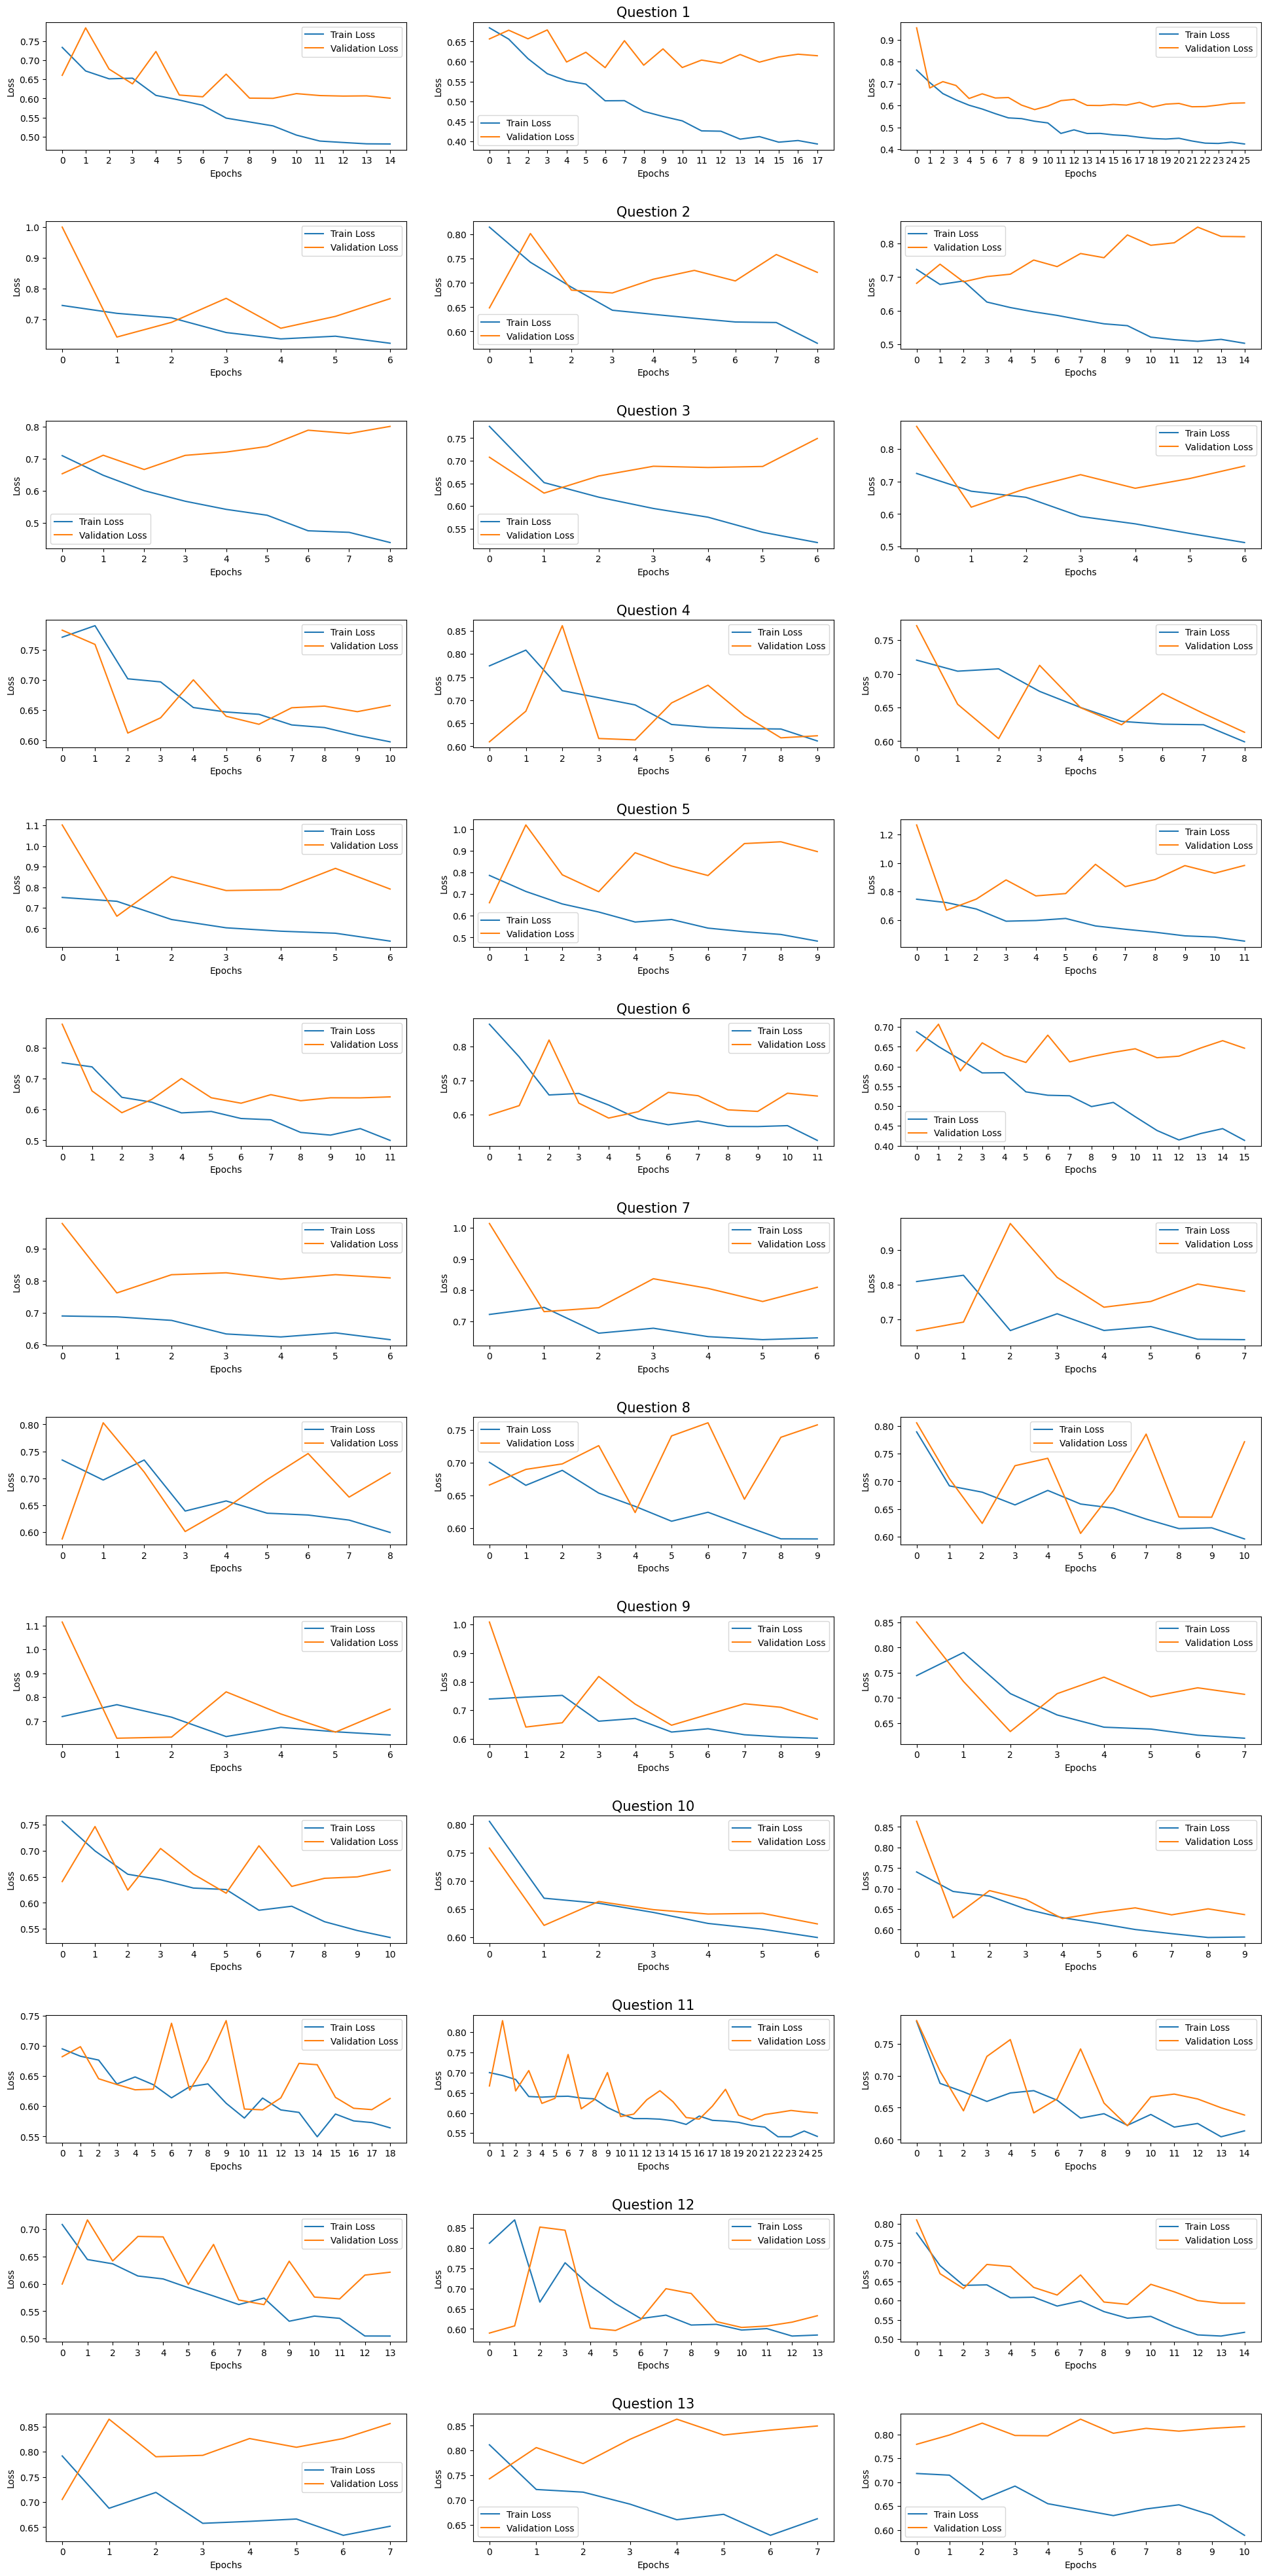

In [ ]:
import matplotlib.pyplot as plt

def plot_tuple_grid(data):
    # Create the figure and axes
    fig, axes = plt.subplots(nrows=len(data), ncols=3, figsize=(20, 40))

    # Iterate over the data and plot each tuple in the corresponding axes
    for i, tuple_data in enumerate(data):
        j = 0
        axes[i][1].set_title(f"Question {i+1}", fontsize=15)
        for tensor_list in tuple_data:
            ax = axes[i][j]

            # Plot the tensors using your desired plot function
            # For example, assuming each tensor list contains x and y coordinates:
            train = [tensor.cpu() for tensor in tensor_list[0]]
            val = [tensor.cpu() for tensor in tensor_list[1]]

            ax.plot(train, label="Train Loss")
            ax.plot(val, label="Validation Loss")

            # Set labels and legend
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()

            num_epochs = len(train)
            x_ticks = range(num_epochs)
            ax.set_xticks(x_ticks)

            j += 1

    # Adjust spacing and layout
    fig.tight_layout(pad=3)

    # Show the plot
    plt.show()


plot_tuple_grid(loss_history)

In [ ]:
results.to_csv("/content/gdrive/MyDrive/daiwoz/Qresults/wav2vec.csv")